# Electric Motor Temperature Data Summary

This data comes from kaggle and is based on electric car features. The publisher's goal is to use this data to predict the permanent magnet synchronous motor temperature, which could prevent overheating. The data is normalized.

## Part 1: Data Formatting

In [1]:
# Libraries:
import pandas as pd
import numpy as np
from os import listdir
from re import search
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
files = listdir("../data")
files.sort()

In [3]:
motor_files = [i for i in files if bool(search("Electric",i))]

In [4]:
# Import the data:
electric_motor_data = []
for i in range(0, len(motor_files)):
    path = "../data/" + motor_files[i]
    if i == 0:
        electric_motor_data.append(pd.read_csv(path, header=0))
        col_names = electric_motor_data[0].columns
        continue
    electric_motor_data.append(pd.read_csv(path, header = None, names = col_names))

# Combine the data:
electric_data = pd.concat(electric_motor_data)

First, we check the data types and check for missing values.

In [5]:
# Data types:
electric_data.dtypes

u_q               float64
coolant           float64
stator_winding    float64
u_d               float64
stator_tooth      float64
motor_speed       float64
i_d               float64
i_q               float64
pm                float64
stator_yoke       float64
ambient           float64
torque            float64
profile_id          int64
dtype: object

Before implementing the algorithm on this data set, we will remove the "profile_id" variable.

In [6]:
electric_data = electric_data.iloc[:, electric_data.columns != "profile_id"]

In [7]:
# Missing values:
print(all(electric_data.isna() == False))
print(all(electric_data.isnull() == False))

True
True


All columns have a numeric data type and there does not appear to be any missing values.

In [8]:
# Check the data set shape
electric_data.shape

(1330816, 12)

The data set contains 1,330,816 observations with 13 total variables. The predictor variables include voltage q-component measurement(u_q), coolant temperature(degree celsius), stator winding temperature(degree celsius), voltage d-component measurement(u_d), strator tooth temperature(degree Celsius), motor speed(rpm), current d-component measurement(i_d), current q-component measurement(i_q), stator yoke(degree celsius), ambient temperature(degree Celsius) and motor torque(Nm). The response variable is the permanent magnet temperature(pm - degree celsius).

# Part 2: Descriptive Statistics

This section provides a "concise" overview of the data. As explained in the data description on Kaggle, this data set is normalized and, therefore, we do not provide the mean, minimum, maximum, and standard deviation for the variables.

The following table shows the correlations between the variables.

In [9]:
electric_data.corr()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
u_q,1.000000,0.051721,0.050610,0.004702,0.104373,0.683556,-0.100357,-0.124589,0.122365,0.090992,0.150264,-0.136215
coolant,0.051721,1.000000,0.504835,0.195517,0.674974,0.011872,0.074865,-0.256389,0.467117,0.860750,0.525963,-0.257982
stator_winding,0.050610,0.504835,1.000000,-0.234950,0.970135,0.432034,-0.624370,0.065617,0.795893,0.860268,0.333208,0.095510
u_d,0.004702,0.195517,-0.234950,1.000000,-0.142749,-0.288472,0.448331,-0.723069,-0.172031,-0.008098,0.203647,-0.753779
stator_tooth,0.104373,0.674974,0.970135,-0.142749,1.000000,0.398431,-0.487062,-0.042294,0.832084,0.953115,0.443470,-0.018413
motor_speed,0.683556,0.011872,0.432034,-0.288472,0.398431,1.000000,-0.700609,-0.068881,0.458947,0.255790,0.118232,-0.043903
i_d,-0.100357,0.074865,-0.624370,0.448331,-0.487062,-0.700609,1.000000,-0.231344,-0.427736,-0.278005,0.016397,-0.274097
i_q,-0.124589,-0.256389,0.065617,-0.723069,-0.042294,-0.068881,-0.231344,1.000000,-0.142416,-0.131466,-0.314044,0.996457
pm,0.122365,0.467117,0.795893,-0.172031,0.832084,0.458947,-0.427736,-0.142416,1.000000,0.756684,0.513728,-0.117138
stator_yoke,0.090992,0.860750,0.860268,-0.008098,0.953115,0.255790,-0.278005,-0.131466,0.756684,1.000000,0.520382,-0.117118


In the table above, stator_winding, stator_tooth, and stator_yoke are highly correlated with the response variable pm. Coolant, motor_speed, i_d(negative), and ambient are moderately correlated with pm. To get a better view of the correlations between predictors, we use a correlation heatmap.  

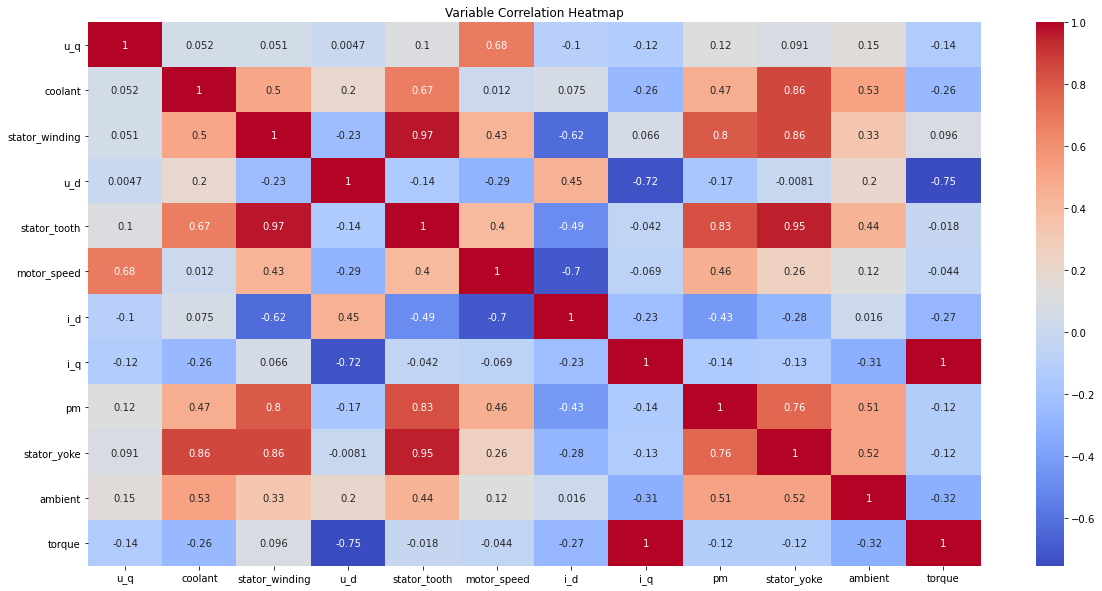

In [10]:
fig = plt.figure(figsize = (20,10))
plt.title("Variable Correlation Heatmap")
sns.heatmap(electric_data.corr(), cmap = "coolwarm", annot=True);

In the heatmap, there are several predictor variables that have high positive and negative correlations with other predictor variables. For example, torque has a high negative correlation with u_d and a high positive correlation with i_q. These high correlations between the variables indicate possible multicollinearity. However, multicollinearity is not a major issue for prediction and, as we may see, the penalties for certain models may help stabalize the coefficients.

## Histogram Plots

In [11]:
# Function to generate the histograms:
def create_histo(num_rows = 2, num_cols= 2, start_point = 0, stop_point = 5):
    """
    This function creates histograms for the numeric variables in the electric motor temperature data set.
    Parameters:
        num_rows: Number of rows for histogram display(max 4).
        num_cols: Number of columns for histogram display(Recommended 3).
        start_point: Index for the first variable to be plotted.
        stop_point: Index for the last variable to be plotted.
    """
    fig_new, axs = plt.subplots(nrows = num_rows, ncols= num_cols, figsize = (15, 10.27))
    var_start_index = start_point
    for i in range(0, num_rows):
        for j in range(0, num_cols):
            sns.histplot(electric_data.loc[:,electric_data.columns[electric_data.dtypes != "bool"][var_start_index]], kde = False, 
                     bins = 10, color = 'darkblue', ax = axs[i,j])
            axs[i,j].set_title(electric_data.columns[electric_data.dtypes != "bool"][var_start_index] + " Histogram")
            var_start_index += 1
            if var_start_index == stop_point:
                return()

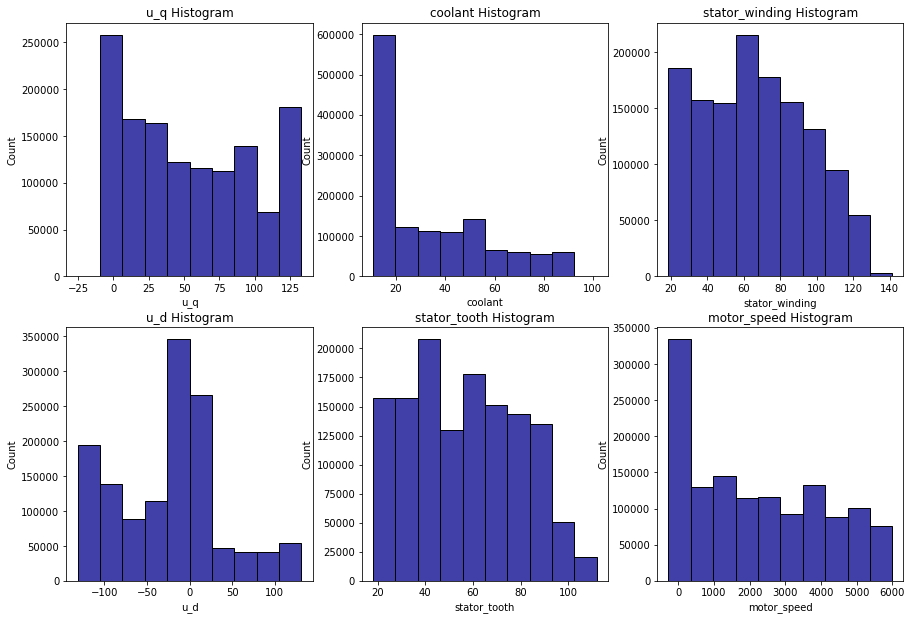

In [12]:
# First 6 variables:
create_histo(2, 3, 0, 6);

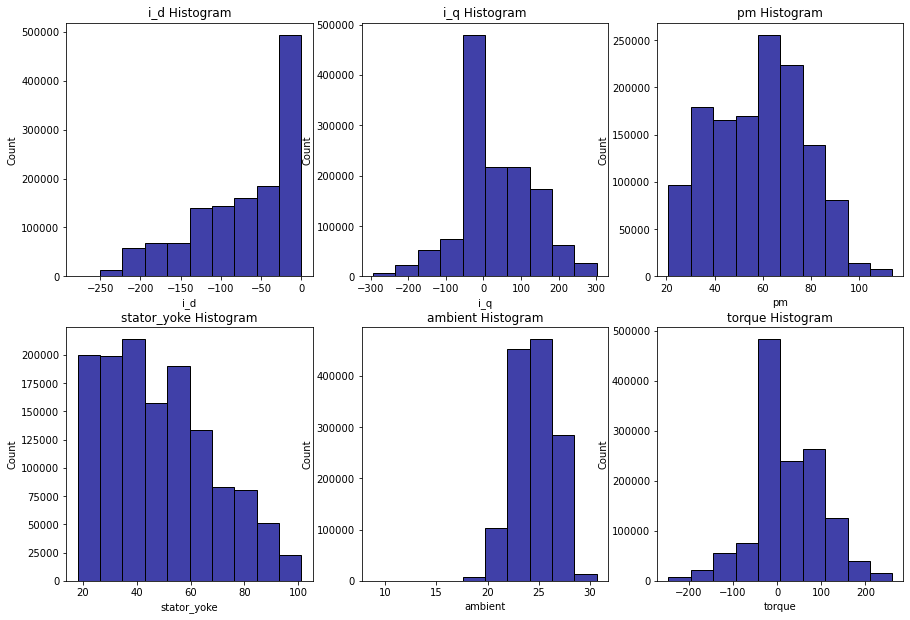

In [13]:
# Last 6 variables:
create_histo(2, 3,6, 12);